In [1]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly
import datetime
import seaborn as sns

from utils import market_values, market_values_by_time_index

In [2]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
n.storage_units_t.p

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.012865,0.041039,0.003039,-0.009721,0.009953,-0.036106,0.013979,319.190476,72.512364,1165.298713,...,0.003265,0.015847,0.019115,0.043090,288.543736,0.016225,59.590499,730.785534,0.003466,98.603409
2013-01-01 03:00:00,0.012841,0.024226,0.002972,-0.010176,0.009789,-0.011099,0.024839,319.190472,1159.076994,1165.298695,...,0.003257,0.010948,0.012895,0.065493,288.689276,0.011146,40.199534,730.785526,0.015739,94.322064
2013-01-01 06:00:00,0.008043,0.015460,0.002940,-0.040535,0.007463,-0.027069,0.021429,319.189436,0.026051,1165.298007,...,0.004014,0.014472,0.017224,0.064525,288.715495,0.014713,0.001124,730.783770,0.011896,0.054735
2013-01-01 09:00:00,0.002082,-542.779577,0.002591,-1829.290856,0.002801,-0.078550,0.015965,0.014910,-1398.984653,0.018543,...,0.008538,0.015898,0.016398,-91.977821,0.011502,0.016099,-184.992470,0.025293,-1021.272174,0.002086
2013-01-01 12:00:00,0.006093,-0.093714,0.002674,-32.098796,0.006246,-0.184040,0.015972,319.189435,0.045875,1165.298061,...,29.786837,204.697089,176.195500,0.012741,55.011600,197.137294,-0.008166,730.783337,-0.053098,0.010078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.006801,-2411.990162,0.001668,-0.008033,0.010581,-1163.908127,0.005519,319.189913,0.038533,1165.298066,...,0.006355,0.024361,0.016715,-0.099673,0.053854,0.022366,0.030740,730.785091,-0.094936,78.185793
2013-12-31 12:00:00,0.006966,-1169.808270,0.002522,-0.009887,0.010383,-0.064200,0.008708,319.189958,0.041612,1165.298126,...,0.007661,0.022220,0.023819,-0.162239,0.052338,0.022571,0.007974,730.784440,-0.041091,789.270206
2013-12-31 15:00:00,0.007940,0.258793,0.003204,-0.001086,0.012742,-0.088930,0.008626,319.190484,739.465403,1165.298713,...,0.007500,0.022204,0.023620,-0.098356,0.051981,0.022462,0.267197,730.785448,-0.007880,791.920057


In [5]:
# overall generation: active power at bus (positive if net generation at bus) in MW
n.buses_t.p

Bus,AL0 0,AL0 0 EV battery,AL0 0 H2,AL0 0 H2 liquid,AL0 0 battery,AL0 0 home battery,AL0 0 low voltage,AL0 0 residential rural heat,AL0 0 residential rural water tanks,AL0 0 residential urban decentral heat,...,SK0 0 services rural water tanks,SK0 0 services urban decentral heat,SK0 0 services urban decentral water tanks,SK0 0 urban central heat,SK0 0 urban central water tanks,co2 atmosphere,co2 stored,gas for industry,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-608.163407,-9.079289e-08,2.133122e-06,4.495180e-07,1.635940e-06,-9.534975e-07,-5.313130e-08,0.000006,-1.489416e-08,-0.000008,...,-7.055290e-09,0.000048,-8.912204e-09,0.000069,-1.881899e-08,-4.887948e-07,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-01-01 03:00:00,-581.055247,-3.748977e-07,1.160617e-06,4.495180e-07,4.570022e-07,-1.197959e-06,-6.548025e-07,-0.000039,-8.509398e-09,-0.000025,...,-1.044024e-08,-0.000060,-9.961686e-09,-0.000086,7.794030e-09,8.283217e-08,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-01-01 06:00:00,1754.697653,1.512844e-07,-8.014138e-07,4.495180e-07,-2.234797e-04,6.834004e-08,6.329118e-08,0.000019,-9.922386e-09,-0.000016,...,-8.740590e-09,-0.000041,-8.521342e-09,-0.000059,1.400640e-08,-4.886566e-07,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-01-01 09:00:00,2405.927337,-4.500230e-07,-1.237522e-06,4.495180e-07,-4.573655e-04,-5.502602e-07,1.322039e-07,-0.000004,-9.791693e-09,-0.000016,...,-6.147678e-09,0.000031,-8.773595e-09,0.000043,-1.388392e-08,-4.888938e-07,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-01-01 12:00:00,1066.208332,2.821321e-07,3.324496e-07,4.495180e-07,-4.594787e-04,4.810797e-07,5.638632e-08,-0.000024,-2.027343e-09,-0.000011,...,-1.010557e-08,-0.000077,-8.167377e-09,-0.000108,4.557956e-09,-4.885105e-07,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,408.769997,1.247315e-09,-4.095881e-07,4.495180e-07,-4.541463e-04,-3.169613e-08,-1.714413e-07,0.000028,-1.421219e-08,-0.000011,...,-1.249301e-08,-0.000019,-1.077348e-08,-0.000026,-2.521626e-08,-4.889882e-07,-0.000045,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-12-31 12:00:00,151.545199,-3.360129e-07,2.329806e-07,4.495180e-07,-2.595504e-04,-2.222809e-07,-4.818554e-08,-0.000017,-1.069220e-08,0.000005,...,-1.170578e-08,0.000052,-1.001687e-08,0.000074,-4.497013e-08,-4.888327e-07,-0.000041,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-12-31 15:00:00,3009.872193,9.805703e-08,-1.437836e-06,4.495180e-07,-3.357515e-06,-3.122251e-07,-3.109597e-07,0.000012,-3.233202e-09,-0.000008,...,-6.176270e-09,-0.000065,-1.008166e-08,-0.000093,1.273984e-08,-4.888315e-07,-0.000036,-3.744317e-07,-3.287678e-07,1.735170e-07


In [6]:
n.generators_t.p_max_pu

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 residential rural solar thermal collector,AL0 0 residential urban decentral solar thermal collector,AL0 0 services rural solar thermal collector,AL0 0 services urban decentral solar thermal collector,AL0 0 solar,AL0 0 solar rooftop,AL0 0 urban central solar thermal collector,AT0 0 onwind,...,SI0 0 urban central solar thermal collector,SK0 0 onwind,SK0 0 residential rural solar thermal collector,SK0 0 residential urban decentral solar thermal collector,SK0 0 ror,SK0 0 services rural solar thermal collector,SK0 0 services urban decentral solar thermal collector,SK0 0 solar,SK0 0 solar rooftop,SK0 0 urban central solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.212092,...,0.000000,0.370957,0.000000,0.000000,0.106059,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199429,...,0.000000,0.410429,0.000000,0.000000,0.106347,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.212342,0.212342,0.000000,0.149067,...,0.000000,0.425850,0.000000,0.000000,0.106370,0.000000,0.000000,0.096427,0.096427,0.000000
2013-01-01 09:00:00,0.000000,0.000000,0.258074,0.258074,0.258074,0.258074,0.509680,0.509680,0.258074,0.063472,...,0.158844,0.311015,0.035745,0.035745,0.106495,0.035745,0.035745,0.342504,0.342504,0.035745
2013-01-01 12:00:00,0.000000,0.000000,0.252337,0.252337,0.252337,0.252337,0.282403,0.282403,0.252337,0.021450,...,0.188041,0.225632,0.084352,0.084352,0.106541,0.084352,0.084352,0.161330,0.161330,0.084352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,0.020393,0.020393,0.020393,0.020393,0.217482,0.217482,0.020393,0.019345,...,0.000000,0.011574,0.000000,0.000000,0.158794,0.000000,0.000000,0.163296,0.163296,0.000000
2013-12-31 12:00:00,0.000000,0.000000,0.016879,0.016879,0.016879,0.016879,0.132394,0.132394,0.016879,0.055680,...,0.010854,0.031714,0.000000,0.000000,0.157693,0.000000,0.000000,0.100254,0.100254,0.000000
2013-12-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083365,...,0.000000,0.076537,0.000000,0.000000,0.157553,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
lmp_regions = n.buses_t.marginal_price.loc[:, n.buses.location.unique()[:-1]]
lmp_regions.columns

Index(['AL0 0', 'AT0 0', 'AT0 1', 'AT0 2', 'BA0 0', 'BE0 0', 'BE0 1', 'BE0 2',
       'BE0 3', 'BE0 4',
       ...
       'SE3 0', 'SE3 1', 'SE3 2', 'SE3 3', 'SE3 4', 'SE3 5', 'SE3 6', 'SE3 7',
       'SI0 0', 'SK0 0'],
      dtype='object', name='Bus', length=181)

Text(0, 0.5, 'Market clearing price in EUR/MWh)')

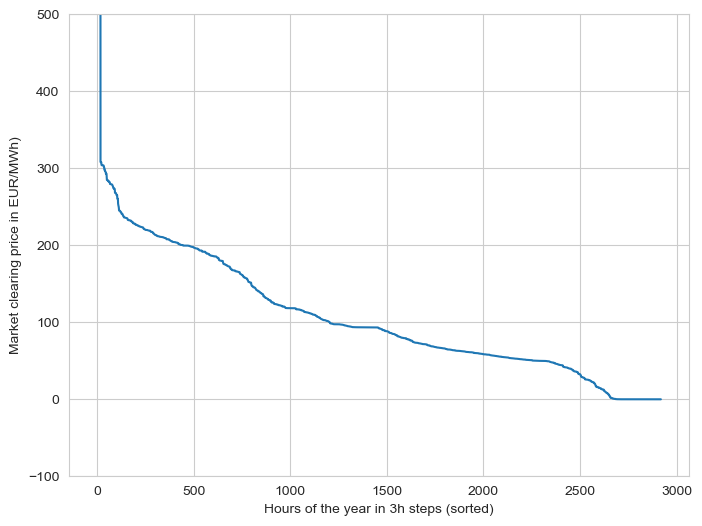

In [8]:
# price duration curve per region
plt.figure(figsize=(8, 6))
plt.plot(lmp_regions['SK0 0'].sort_values(ascending=False).values)
plt.ylim(-100, 500)
plt.xlabel("Hours of the year in 3h steps (sorted)")
plt.ylabel("Market clearing price in EUR/MWh)")

# would be interesting to see which technology is the price setter in the respecting hour
# calculating area under the curve to see how much investment is in the market?

(-100.0, 500.0)

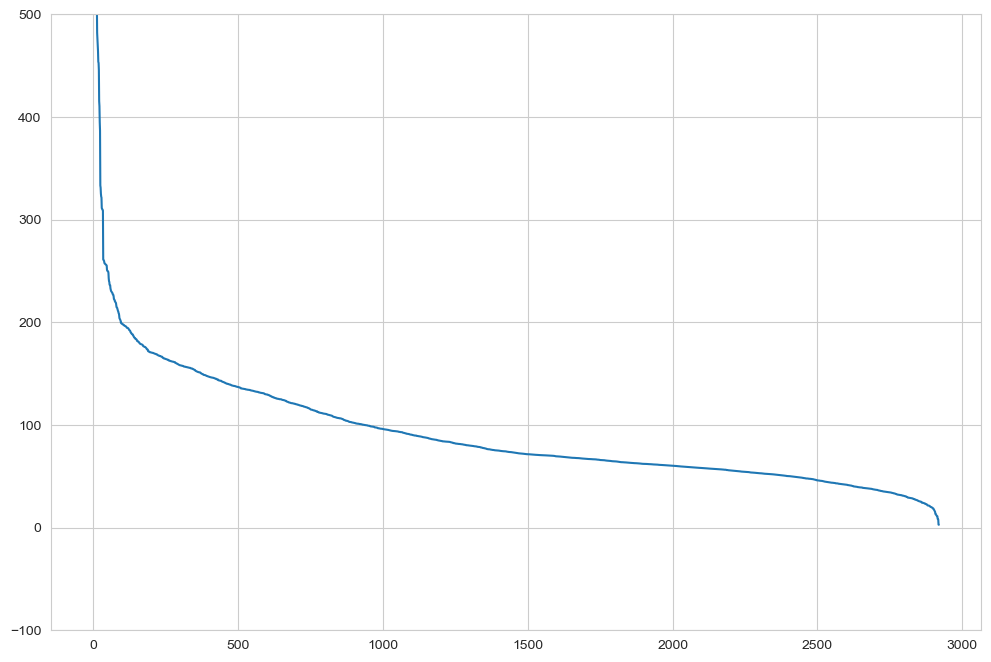

In [9]:
# overall price duration curve (mean aggregation)
plt.figure(figsize=(12, 8))
plt.plot(lmp_regions.mean(axis=1).sort_values(ascending=False).values)
plt.ylim(-100, 500)

- constructing figure from paper Böttger & Härtel
- Figure 17: Power generation and consumption and market values (or capture prices) of individual technologies in the wholesale electricity market of Germany in 2050 for the 28 countries scenario, own illustration based on own computations.
- effect of storage technologies on renewables curtailment (calculate how much energy the storages take from the market that is from a renewable source)
- check wether the market values of renewables lie below the average market value

In [10]:
# merit order for location ALO 0 and first hour
n.all_components

{'Bus',
 'Carrier',
 'Generator',
 'GlobalConstraint',
 'Line',
 'LineType',
 'Link',
 'Load',
 'ShuntImpedance',
 'StorageUnit',
 'Store',
 'SubNetwork',
 'Transformer',
 'TransformerType'}

In [11]:
n.graph
# 3086 buses withing 181 regions?

<bound method graph of PyPSA Network
Components:
 - Bus: 3086
 - Carrier: 30
 - Generator: 1707
 - GlobalConstraint: 3
 - Line: 323
 - Link: 8375
 - Load: 2542
 - StorageUnit: 170
 - Store: 1635
Snapshots: 2920>

In [12]:
n.carriers

,co2_emissions,color,nice_name,max_growth
Carrier,,,,
onwind,0.0,#235ebc,Onshore Wind,inf
offwind-ac,0.0,#6895dd,Offshore Wind (AC),inf
offwind-dc,0.0,#74c6f2,Offshore Wind (DC),inf
solar,0.0,#f9d002,Solar,inf
PHS,0.0,#08ad97,Pumped Hydro Storage,inf
hydro,0.0,#08ad97,Reservoir & Dam,inf
ror,0.0,#4adbc8,Run of River,inf
co2,-1.0,,,inf
gas,0.0,,,inf


In [13]:
n.buses

,v_nom,x,y,country,control,generator,carrier,location,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,,
AL0 0,380.0,19.894573,41.561804,AL,Slack,AL0 0 offwind-ac,AC,AL0 0,,None,1.0,0.0,inf,
AT0 0,380.0,15.759790,47.898676,AT,PQ,,AC,AT0 0,,None,1.0,0.0,inf,
AT0 1,380.0,10.293250,47.248827,AT,PQ,,AC,AT0 1,,None,1.0,0.0,inf,
AT0 2,380.0,13.580650,47.413095,AT,PQ,,AC,AT0 2,,None,1.0,0.0,inf,
BA0 0,380.0,18.122704,43.811367,BA,PQ,,AC,BA0 0,,None,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 5,,None,1.0,0.0,inf,
SE3 6 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 6,,None,1.0,0.0,inf,
SE3 7 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 7,,None,1.0,0.0,inf,


In [14]:
# example of bus and snapshot
bus = "AL0 0" # "DE0 1"
snapshot = "2013-01-02 00:00:00"
buses = n.buses[n.buses.location == bus].index
# 	active power at bus (positive if net generation at bus) in MW
n.buses_t.p.loc[snapshot,buses]

Bus
AL0 0                                            1.053552e+03
AL0 0 H2                                         3.575580e-07
AL0 0 battery                                    1.631594e-06
AL0 0 EV battery                                 1.120065e-07
AL0 0 residential rural heat                     7.564682e-07
AL0 0 residential rural water tanks             -8.344544e-09
AL0 0 services rural heat                        3.698837e-07
AL0 0 services rural water tanks                -8.789289e-09
AL0 0 residential urban decentral heat          -1.885773e-05
AL0 0 residential urban decentral water tanks   -9.288991e-09
AL0 0 services urban decentral heat             -6.340396e-06
AL0 0 services urban decentral water tanks      -6.585114e-09
AL0 0 urban central heat                        -2.202479e-05
AL0 0 urban central water tanks                 -6.778200e-09
AL0 0 H2 liquid                                  4.495180e-07
AL0 0 low voltage                               -3.854633e-07
AL0 

## Generators

In [15]:
# The maximum output for each snapshot per unit of p_nom for the OPF (e.g. for variable renewable generators this can change due to weather conditions; for conventional generators it represents a maximum dispatch).
# p_max_pu is 1 for all generators (for VRE it has the be replaced by the corresponding vlaue from n.generators_t
n.generators.p_max_pu

Generator
AL0 0 offwind-ac       1.0
AL0 0 onwind           1.0
AL0 0 solar            1.0
AT0 0 onwind           1.0
AT0 0 ror              1.0
                      ... 
SE3 5 solar rooftop    1.0
SE3 6 solar rooftop    1.0
SE3 7 solar rooftop    1.0
SI0 0 solar rooftop    1.0
SK0 0 solar rooftop    1.0
Name: p_max_pu, Length: 1707, dtype: float64

In [16]:
# Nominal power for limits in OPF.
# only ror has nominal power limit that is not 0 -> limits in p_nom and p_nom_opt of ror are identical -> use p_nom_opt as nominal power limit for all generators
n.generators.p_nom
n.generators.p_nom_opt

Generator
AL0 0 offwind-ac           0.036797
AL0 0 onwind               0.045414
AL0 0 solar            22582.111710
AT0 0 onwind           23183.878045
AT0 0 ror               1983.000000
                           ...     
SE3 5 solar rooftop        0.055040
SE3 6 solar rooftop       13.444359
SE3 7 solar rooftop        0.071811
SI0 0 solar rooftop     2883.516331
SK0 0 solar rooftop     5426.772848
Name: p_nom_opt, Length: 1707, dtype: float64

In [17]:
# gas and oil are not in n.generators_t.p_max_pu.columns: their maximum output is static / not variable
# and determinded by n.generators.p_nom_opt*n.generators.p_max_pu(=1) in every time step
n.generators.index.difference(pd.Index(n.generators_t.p_max_pu.columns))

Index(['EU gas', 'EU oil'], dtype='object', name='Generator')

In [18]:
# calculate the possible output for the generators for every time step (first without gas and oil)
max_out_gen = n.generators_t.p_max_pu * n.generators.p_nom_opt[n.generators_t.p_max_pu.columns]
max_out_gen

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 residential rural solar thermal collector,AL0 0 residential urban decentral solar thermal collector,AL0 0 services rural solar thermal collector,AL0 0 services urban decentral solar thermal collector,AL0 0 solar,AL0 0 solar rooftop,AL0 0 urban central solar thermal collector,AT0 0 onwind,...,SI0 0 urban central solar thermal collector,SK0 0 onwind,SK0 0 residential rural solar thermal collector,SK0 0 residential urban decentral solar thermal collector,SK0 0 ror,SK0 0 services rural solar thermal collector,SK0 0 services urban decentral solar thermal collector,SK0 0 solar,SK0 0 solar rooftop,SK0 0 urban central solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4917.117060,...,0.000000,2246.745444,0.000000,0.000000,68.018755,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4623.549099,...,0.000000,2485.812618,0.000000,0.000000,68.203733,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4795.138457,559.558005,0.000000,3455.951978,...,0.000000,2579.214662,0.000000,0.000000,68.218391,0.000000,0.000000,3528.493104,523.288028,0.000000
2013-01-01 09:00:00,0.000000,0.000000,0.027331,0.044820,0.027959,0.044439,11509.658048,1343.093917,56.781660,1471.536228,...,0.106235,1883.700377,0.001705,0.001961,68.298339,0.001729,0.001950,12533.028763,1858.692568,0.007503
2013-01-01 12:00:00,0.000000,0.000000,0.026724,0.043823,0.027338,0.043451,6377.260615,744.180227,55.519468,497.304199,...,0.125763,1366.565650,0.004024,0.004629,68.328177,0.004080,0.004601,5903.451839,875.502823,0.017705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,0.002160,0.003542,0.002209,0.003512,4911.213393,573.103111,4.486864,448.491166,...,0.000000,70.099698,0.000000,0.000000,101.839522,0.000000,0.000000,5975.394047,886.172107,0.000000
2013-12-31 12:00:00,0.000000,0.000000,0.001788,0.002931,0.001829,0.002906,2989.746044,348.881757,3.713676,1290.885816,...,0.007259,192.078301,0.000000,0.000000,101.133427,0.000000,0.000000,3668.540262,544.057518,0.000000
2013-12-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1932.716350,...,0.000000,463.553013,0.000000,0.000000,101.043454,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
n.generators_t.p[n.generators_t.p_max_pu.columns]

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 residential rural solar thermal collector,AL0 0 residential urban decentral solar thermal collector,AL0 0 services rural solar thermal collector,AL0 0 services urban decentral solar thermal collector,AL0 0 solar,AL0 0 solar rooftop,AL0 0 urban central solar thermal collector,AT0 0 onwind,...,SI0 0 urban central solar thermal collector,SK0 0 onwind,SK0 0 residential rural solar thermal collector,SK0 0 residential urban decentral solar thermal collector,SK0 0 ror,SK0 0 services rural solar thermal collector,SK0 0 services urban decentral solar thermal collector,SK0 0 solar,SK0 0 solar rooftop,SK0 0 urban central solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4917.113011,...,0.000000,2246.743658,0.000000,0.000000,68.016233,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4623.535568,...,0.000000,2485.810713,0.000000,0.000000,68.201206,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4795.128080,559.554683,0.000000,3455.948969,...,0.000000,2579.209744,0.000000,0.000000,68.215779,0.000000,0.000000,3528.485426,523.284014,0.000000
2013-01-01 09:00:00,0.000000,0.000000,0.024807,0.043897,0.025474,0.043574,11509.646090,1343.090499,56.779796,1471.522842,...,0.103578,117.748709,0.000978,0.001229,39.266101,0.000991,0.001221,12031.508302,1858.687944,0.005578
2013-01-01 12:00:00,0.000000,0.000000,0.024316,0.042932,0.024975,0.042603,6377.253396,744.177184,55.517754,497.291894,...,0.123193,1366.563887,0.002605,0.003413,68.325025,0.002637,0.003395,5903.436923,875.497826,0.015649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,0.001178,0.002385,0.001201,0.002407,4911.200758,573.099831,4.484426,448.489909,...,0.000000,70.096230,0.000000,0.000000,101.836988,0.000000,0.000000,5975.378402,886.166876,0.000000
2013-12-31 12:00:00,0.000000,0.000000,0.000949,0.001887,0.000969,0.001911,2989.734046,348.878559,3.711222,1290.876086,...,0.005482,192.076450,0.000000,0.000000,101.130892,0.000000,0.000000,3668.524451,544.052274,0.000000
2013-12-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1932.721807,...,0.000000,463.552587,0.000000,0.000000,101.041015,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
# compare to real output
out_ratio = n.generators_t.p[n.generators_t.p_max_pu.columns] / max_out_gen
out_diff = max_out_gen -n.generators_t.p[n.generators_t.p_max_pu.columns]

In [21]:
#out_ratio
#out_diff

In [22]:
# indicate which generator is marginal generator
th_ratio = 0.95
th_prod = 0.05

# ratio has to be lower than threshold
out_ratio[out_ratio < th_ratio] = 0.5
# output has to be greater than threshold (relatively to max_output) and greater than 1 MW
out_prod = n.generators_t.p[n.generators_t.p_max_pu.columns].copy()
out_prod[(out_prod > (max_out_gen*th_prod)) & (out_prod > 1)] = 0.5
out_incidence = out_ratio + out_prod
out_incidence[out_incidence != 1] = 0
out_incidence = out_incidence.astype(int)
#out_incidence

315

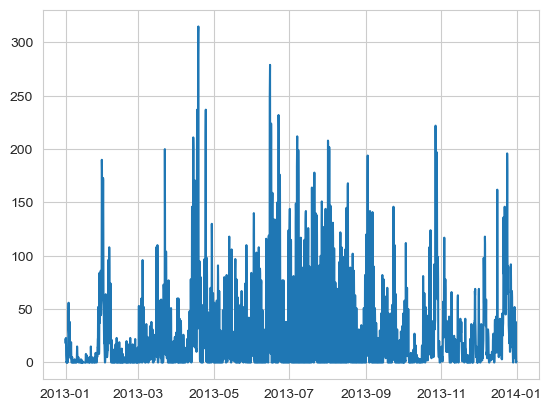

In [23]:
# number can be higher than 181 as there are also generators for other technologies not just electricity
plt.plot(out_incidence.sum(axis=1))
out_incidence.sum(axis=1).max()

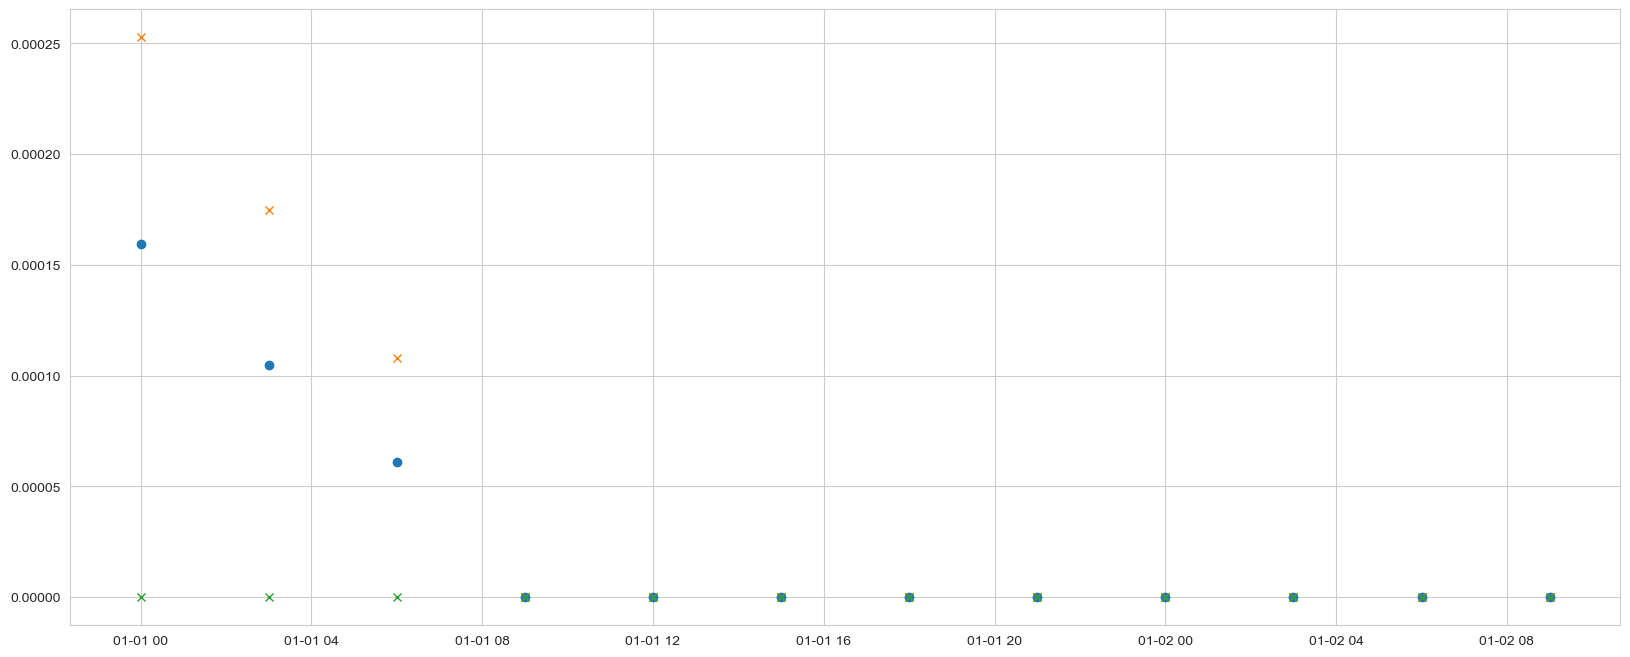

In [24]:
# check results
gen = "AT0 1 onwind" # AL0 0 solar, AT0 1 onwind
start = 0
end = 12

plt.figure(figsize=(20, 8))
plt.plot(n.generators_t.p[gen][start:end], "o")
plt.plot(max_out_gen[gen][start:end], "x")
plt.plot(out_incidence[gen][start:end]*max_out_gen[gen][start:end].mean(),"x")

#### Problems
- for very low possible VRE output, the indication is often set but, the technology is surely not the marginal generator (check AT0 1 onwind) first 3 hours (corrected by adding constraint for minimum output of 1 MW)


## Storages

In [25]:
# Challenge1: comparing only the actual output with the product of nominal power and maximum output is not sufficient as the storage can be empty / not sufficiently full ?
# Challenge2: the real output can be either positive or negative (when storing energy)
# n.storage_units.p_nom == n.storage_units.p_nom_opt is True -> you can use both
# n.storage_units.index.difference(pd.Index(n.storage_units_t.p.columns)) -> no difference in indices

In [26]:
n.storage_units.index

Index(['AT0 0 hydro', 'AT0 1 PHS', 'AT0 1 hydro', 'AT0 2 PHS', 'AT0 2 hydro',
       'BE0 1 PHS', 'BE0 1 hydro', 'BG0 0 hydro', 'BG0 1 PHS', 'BG0 1 hydro',
       ...
       'SE3 3 hydro', 'SE3 4 hydro', 'SE3 5 hydro', 'SE3 6 PHS', 'SE3 6 hydro',
       'SE3 7 hydro', 'SI0 0 PHS', 'SI0 0 hydro', 'SK0 0 PHS', 'SK0 0 hydro'],
      dtype='object', name='StorageUnit', length=170)

In [27]:
# calculate the possible output for the generators for every time step
max_output = n.storage_units.p_max_pu * n.storage_units.p_nom_opt
# max_output = pd.DataFrame(max_output.values.reshape(1,170), columns=max_output.index)
# max_output

In [28]:
# real output
n.storage_units_t.p

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.012865,0.041039,0.003039,-0.009721,0.009953,-0.036106,0.013979,319.190476,72.512364,1165.298713,...,0.003265,0.015847,0.019115,0.043090,288.543736,0.016225,59.590499,730.785534,0.003466,98.603409
2013-01-01 03:00:00,0.012841,0.024226,0.002972,-0.010176,0.009789,-0.011099,0.024839,319.190472,1159.076994,1165.298695,...,0.003257,0.010948,0.012895,0.065493,288.689276,0.011146,40.199534,730.785526,0.015739,94.322064
2013-01-01 06:00:00,0.008043,0.015460,0.002940,-0.040535,0.007463,-0.027069,0.021429,319.189436,0.026051,1165.298007,...,0.004014,0.014472,0.017224,0.064525,288.715495,0.014713,0.001124,730.783770,0.011896,0.054735
2013-01-01 09:00:00,0.002082,-542.779577,0.002591,-1829.290856,0.002801,-0.078550,0.015965,0.014910,-1398.984653,0.018543,...,0.008538,0.015898,0.016398,-91.977821,0.011502,0.016099,-184.992470,0.025293,-1021.272174,0.002086
2013-01-01 12:00:00,0.006093,-0.093714,0.002674,-32.098796,0.006246,-0.184040,0.015972,319.189435,0.045875,1165.298061,...,29.786837,204.697089,176.195500,0.012741,55.011600,197.137294,-0.008166,730.783337,-0.053098,0.010078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.006801,-2411.990162,0.001668,-0.008033,0.010581,-1163.908127,0.005519,319.189913,0.038533,1165.298066,...,0.006355,0.024361,0.016715,-0.099673,0.053854,0.022366,0.030740,730.785091,-0.094936,78.185793
2013-12-31 12:00:00,0.006966,-1169.808270,0.002522,-0.009887,0.010383,-0.064200,0.008708,319.189958,0.041612,1165.298126,...,0.007661,0.022220,0.023819,-0.162239,0.052338,0.022571,0.007974,730.784440,-0.041091,789.270206
2013-12-31 15:00:00,0.007940,0.258793,0.003204,-0.001086,0.012742,-0.088930,0.008626,319.190484,739.465403,1165.298713,...,0.007500,0.022204,0.023620,-0.098356,0.051981,0.022462,0.267197,730.785448,-0.007880,791.920057


In [29]:
max_output_ts = n.storage_units_t.p.copy()
for snap in n.storage_units_t.p.index:
    max_output_ts.loc[snap] = max_output[n.storage_units_t.p.columns]
max_output_ts

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 03:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 06:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 09:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 12:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-12-31 12:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-12-31 15:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0


In [30]:
n.storage_units_t.p

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.012865,0.041039,0.003039,-0.009721,0.009953,-0.036106,0.013979,319.190476,72.512364,1165.298713,...,0.003265,0.015847,0.019115,0.043090,288.543736,0.016225,59.590499,730.785534,0.003466,98.603409
2013-01-01 03:00:00,0.012841,0.024226,0.002972,-0.010176,0.009789,-0.011099,0.024839,319.190472,1159.076994,1165.298695,...,0.003257,0.010948,0.012895,0.065493,288.689276,0.011146,40.199534,730.785526,0.015739,94.322064
2013-01-01 06:00:00,0.008043,0.015460,0.002940,-0.040535,0.007463,-0.027069,0.021429,319.189436,0.026051,1165.298007,...,0.004014,0.014472,0.017224,0.064525,288.715495,0.014713,0.001124,730.783770,0.011896,0.054735
2013-01-01 09:00:00,0.002082,-542.779577,0.002591,-1829.290856,0.002801,-0.078550,0.015965,0.014910,-1398.984653,0.018543,...,0.008538,0.015898,0.016398,-91.977821,0.011502,0.016099,-184.992470,0.025293,-1021.272174,0.002086
2013-01-01 12:00:00,0.006093,-0.093714,0.002674,-32.098796,0.006246,-0.184040,0.015972,319.189435,0.045875,1165.298061,...,29.786837,204.697089,176.195500,0.012741,55.011600,197.137294,-0.008166,730.783337,-0.053098,0.010078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.006801,-2411.990162,0.001668,-0.008033,0.010581,-1163.908127,0.005519,319.189913,0.038533,1165.298066,...,0.006355,0.024361,0.016715,-0.099673,0.053854,0.022366,0.030740,730.785091,-0.094936,78.185793
2013-12-31 12:00:00,0.006966,-1169.808270,0.002522,-0.009887,0.010383,-0.064200,0.008708,319.189958,0.041612,1165.298126,...,0.007661,0.022220,0.023819,-0.162239,0.052338,0.022571,0.007974,730.784440,-0.041091,789.270206
2013-12-31 15:00:00,0.007940,0.258793,0.003204,-0.001086,0.012742,-0.088930,0.008626,319.190484,739.465403,1165.298713,...,0.007500,0.022204,0.023620,-0.098356,0.051981,0.022462,0.267197,730.785448,-0.007880,791.920057


In [31]:
# compare to real output
out_ratio = n.storage_units_t.p / max_output_ts
out_diff = max_output_ts -  n.storage_units_t.p

In [32]:
#out_ratio

In [33]:
#out_diff

In [34]:
# indicate which storage_unit is marginal storage_unit

# ratio has to be lower than threshold
out_ratio[out_ratio < th_ratio] = 0.5 # th_ratio
# output has to be greater than threshold (relatively to max_output) and greater than 1 MW
out_prod = n.storage_units_t.p.copy()
out_prod[(out_prod > (max_output_ts*th_prod)) & (out_prod > 1)] = 0.5 # th_prod
out_incidence_su = out_ratio + out_prod
out_incidence_su[out_incidence_su != 1] = 0
out_incidence_su = out_incidence_su.astype(int)
out_incidence_su

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2013-01-01 06:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 12:00:00,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2013-12-31 12:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31 15:00:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


87

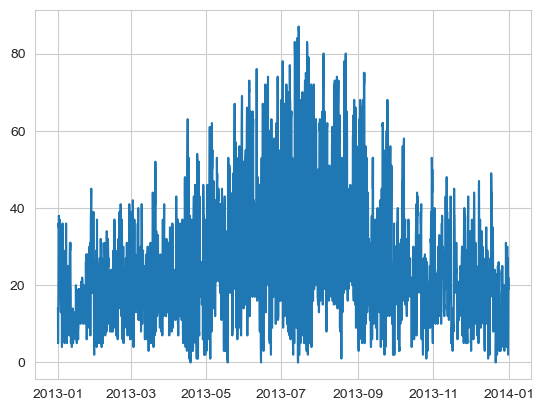

In [35]:
# number can be higher than 181 as there are also generators for other technologies not just electricity
plt.plot(out_incidence_su.sum(axis=1))
out_incidence_su.sum(axis=1).max()

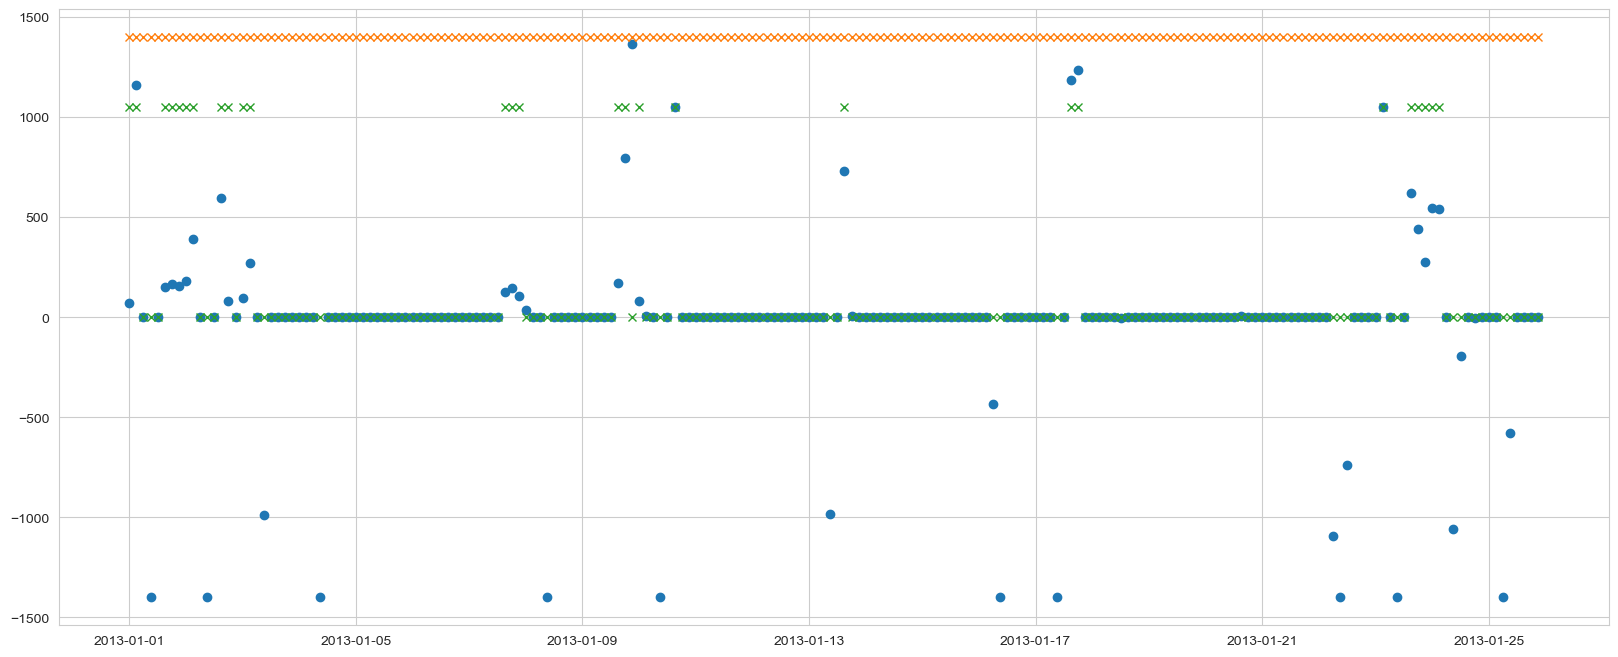

In [36]:
# check results
su = "BG0 1 PHS" # "BG0 1 hydro"; BG0 1 PHS
start = 0
end = 200

plt.figure(figsize=(20, 8))
plt.plot(n.storage_units_t.p[su][start:end], "o")
plt.plot(max_output_ts[su][start:end], "x")
plt.plot(out_incidence_su[su][start:end]*max_output_ts[su][start:end].mean()*0.75, "x")

## Stores

In [37]:
n.stores

,bus,carrier,e_nom_extendable,e_cyclic,capital_cost,e_initial,e_min_pu,e_nom,e_nom_max,lifetime,...,e_nom_opt,type,e_nom_min,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,
co2 atmosphere,co2 atmosphere,co2,True,False,0.000000,0.0,-1.0,0.0,inf,inf,...,3.931254e+07,,0.0,1.0,False,True,0.0,0.0,1.0,0
co2 stored,co2 stored,co2 stored,True,False,20.000000,0.0,0.0,0.0,inf,inf,...,2.000000e+08,,0.0,1.0,False,True,0.0,0.0,1.0,0
EU gas Store,EU gas,gas,True,True,0.000000,0.0,0.0,0.0,inf,inf,...,1.652130e+09,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 0 H2 Store,DE0 0 H2,H2,True,True,140.161529,0.0,0.0,0.0,3.257629e+06,inf,...,5.008064e+05,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 11 H2 Store,DE0 11 H2,H2,True,True,140.161529,0.0,0.0,0.0,3.464642e+08,inf,...,1.257958e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 home battery,SE3 5 home battery,home battery,True,True,17410.953944,0.0,0.0,0.0,inf,25.0,...,5.305105e-01,,0.0,1.0,False,True,0.0,0.0,1.0,0
SE3 6 home battery,SE3 6 home battery,home battery,True,True,17410.953944,0.0,0.0,0.0,inf,25.0,...,4.583297e-01,,0.0,1.0,False,True,0.0,0.0,1.0,0
SE3 7 home battery,SE3 7 home battery,home battery,True,True,17410.953944,0.0,0.0,0.0,inf,25.0,...,5.920071e-01,,0.0,1.0,False,True,0.0,0.0,1.0,0


In [38]:
# Challenge1: comparing only the actual output with the product of nominal power and maximum output is not sufficient as the storage can be empty / not sufficiently full ?
# Challenge2: the real output can be either positive or negative (when storing energy)
# n.stores.e_nom always zero -> use n.stores.e_nom_opt
# n.stores.index.difference(pd.Index(n.stores_t.p.columns)) -> no difference in indices

In [39]:
n.stores.e_nom_min

Store
co2 atmosphere        0.0
co2 stored            0.0
EU gas Store          0.0
DE0 0 H2 Store        0.0
DE0 11 H2 Store       0.0
                     ... 
SE3 5 home battery    0.0
SE3 6 home battery    0.0
SE3 7 home battery    0.0
SI0 0 home battery    0.0
SK0 0 home battery    0.0
Name: e_nom_min, Length: 1635, dtype: float64

In [40]:
# calculate the possible energy capacity for the generators for every time step (not really relevant for our use case) -> maximum output power cannot really be calculated
max_output_e = n.stores.e_max_pu * n.stores.e_nom_opt
max_output_e

Store
co2 atmosphere        3.931254e+07
co2 stored            2.000000e+08
EU gas Store          1.652130e+09
DE0 0 H2 Store        5.008064e+05
DE0 11 H2 Store       1.257958e+06
                          ...     
SE3 5 home battery    5.305105e-01
SE3 6 home battery    4.583297e-01
SE3 7 home battery    5.920071e-01
SI0 0 home battery    6.214827e-01
SK0 0 home battery    9.468182e-01
Length: 1635, dtype: float64

In [41]:
# real output
n.stores_t.p

Store,co2 atmosphere,co2 stored,EU gas Store,DE0 0 H2 Store,DE0 11 H2 Store,DE0 15 H2 Store,DE0 21 H2 Store,DE0 23 H2 Store,DE0 3 H2 Store,DK0 0 H2 Store,...,SE3 0 home battery,SE3 1 home battery,SE3 2 home battery,SE3 3 home battery,SE3 4 home battery,SE3 5 home battery,SE3 6 home battery,SE3 7 home battery,SI0 0 home battery,SK0 0 home battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,20843.470423,-16411.906982,-151420.014744,-3894.885758,-4674.950921,-9088.220733,-7412.905951,-3735.788301,-5047.226945,-9467.747646,...,-0.044617,-0.050180,-0.045123,-0.045475,-0.047361,-0.025025,0.021426,-0.063942,0.020299,-0.017231
2013-01-01 03:00:00,7315.215804,-17159.105936,-71476.180021,-3863.637011,-1887.188696,-8899.421526,-7303.065386,-3695.746641,-5016.524975,7825.465055,...,-0.008823,-0.008715,-0.008874,-0.016073,-0.008381,-0.022349,0.002983,-0.019798,0.031129,-0.011183
2013-01-01 06:00:00,12017.096327,-17825.137679,-76620.116482,-3819.766092,1308.640560,-1843.925405,-6684.191877,-3639.247276,-4973.570908,13807.915648,...,-0.010499,-0.009328,-0.003232,-0.037302,-0.008620,-0.011886,0.004513,-0.020521,0.049881,-0.005023
2013-01-01 09:00:00,17439.765973,-18879.470962,-115639.173112,376.981943,2304.352827,-1223.338004,-7179.232816,-3658.094157,-4988.098060,10294.940973,...,-0.032689,-0.037058,-0.039628,-0.006899,-0.041419,-0.060817,-0.004135,-0.047279,-0.103260,-0.021628
2013-01-01 12:00:00,18601.748172,-22185.459268,-105642.327535,-478.303340,261.844132,3329.156597,-2043.601248,472.832254,-1494.121743,6415.914999,...,0.037458,0.037765,0.038423,0.048879,0.041668,0.061998,-0.003336,0.047962,-0.091202,-0.013102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,18603.761310,-13739.664255,-140657.811739,-3833.329810,-3524.685520,-3817.572634,-7194.256470,-1054.244211,2042.139171,-4917.753421,...,-0.060155,-0.057707,-0.067638,-0.053226,-0.011701,-0.097498,-0.050076,-0.038554,-0.000781,-0.115798
2013-12-31 12:00:00,20940.100642,-15040.627331,-147329.207411,376.152227,-3405.472043,-1703.564195,-2017.852764,1892.547273,1322.194168,1022.645760,...,0.015274,0.006457,0.013450,0.026012,-0.016467,0.029663,-0.009253,-0.010273,0.004365,-0.087686
2013-12-31 15:00:00,15211.636525,-17471.692256,-108644.945265,968.325784,-4461.589500,580.465648,325.078829,-153.108069,123.955859,-1119.035072,...,-0.006297,-0.014378,-0.010148,0.000592,-0.013855,-0.011819,-0.021893,-0.017805,-0.004803,0.062905


In [42]:
# set maximum output as maximum possible output
max_output_ts = n.stores_t.p.copy()
for snap in n.stores_t.p.index:
    max_output_ts.loc[snap] = n.stores_t.p[n.stores_t.p.columns].max()
max_output_ts

Store,co2 atmosphere,co2 stored,EU gas Store,DE0 0 H2 Store,DE0 11 H2 Store,DE0 15 H2 Store,DE0 21 H2 Store,DE0 23 H2 Store,DE0 3 H2 Store,DK0 0 H2 Store,...,SE3 0 home battery,SE3 1 home battery,SE3 2 home battery,SE3 3 home battery,SE3 4 home battery,SE3 5 home battery,SE3 6 home battery,SE3 7 home battery,SI0 0 home battery,SK0 0 home battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,27576.491387,26836.4377,689042.959112,1226.001838,10217.403115,7941.828134,3411.691933,3361.316682,5557.385677,22996.736668,...,0.140514,0.149609,0.138761,0.148436,0.138745,0.174605,0.151242,0.191903,0.201675,0.202773
2013-01-01 03:00:00,27576.491387,26836.4377,689042.959112,1226.001838,10217.403115,7941.828134,3411.691933,3361.316682,5557.385677,22996.736668,...,0.140514,0.149609,0.138761,0.148436,0.138745,0.174605,0.151242,0.191903,0.201675,0.202773
2013-01-01 06:00:00,27576.491387,26836.4377,689042.959112,1226.001838,10217.403115,7941.828134,3411.691933,3361.316682,5557.385677,22996.736668,...,0.140514,0.149609,0.138761,0.148436,0.138745,0.174605,0.151242,0.191903,0.201675,0.202773
2013-01-01 09:00:00,27576.491387,26836.4377,689042.959112,1226.001838,10217.403115,7941.828134,3411.691933,3361.316682,5557.385677,22996.736668,...,0.140514,0.149609,0.138761,0.148436,0.138745,0.174605,0.151242,0.191903,0.201675,0.202773
2013-01-01 12:00:00,27576.491387,26836.4377,689042.959112,1226.001838,10217.403115,7941.828134,3411.691933,3361.316682,5557.385677,22996.736668,...,0.140514,0.149609,0.138761,0.148436,0.138745,0.174605,0.151242,0.191903,0.201675,0.202773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,27576.491387,26836.4377,689042.959112,1226.001838,10217.403115,7941.828134,3411.691933,3361.316682,5557.385677,22996.736668,...,0.140514,0.149609,0.138761,0.148436,0.138745,0.174605,0.151242,0.191903,0.201675,0.202773
2013-12-31 12:00:00,27576.491387,26836.4377,689042.959112,1226.001838,10217.403115,7941.828134,3411.691933,3361.316682,5557.385677,22996.736668,...,0.140514,0.149609,0.138761,0.148436,0.138745,0.174605,0.151242,0.191903,0.201675,0.202773
2013-12-31 15:00:00,27576.491387,26836.4377,689042.959112,1226.001838,10217.403115,7941.828134,3411.691933,3361.316682,5557.385677,22996.736668,...,0.140514,0.149609,0.138761,0.148436,0.138745,0.174605,0.151242,0.191903,0.201675,0.202773


In [43]:
# compare to real output
out_ratio = n.stores_t.p / max_output_ts
out_ratio

Store,co2 atmosphere,co2 stored,EU gas Store,DE0 0 H2 Store,DE0 11 H2 Store,DE0 15 H2 Store,DE0 21 H2 Store,DE0 23 H2 Store,DE0 3 H2 Store,DK0 0 H2 Store,...,SE3 0 home battery,SE3 1 home battery,SE3 2 home battery,SE3 3 home battery,SE3 4 home battery,SE3 5 home battery,SE3 6 home battery,SE3 7 home battery,SI0 0 home battery,SK0 0 home battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.755842,-0.611553,-0.219754,-3.176900,-0.457548,-1.144349,-2.172795,-1.111406,-0.908202,-0.411700,...,-0.317529,-0.335408,-0.325187,-0.306360,-0.341353,-0.143321,0.141667,-0.333197,0.100654,-0.084975
2013-01-01 03:00:00,0.265270,-0.639396,-0.103733,-3.151412,-0.184703,-1.120576,-2.140599,-1.099494,-0.902677,0.340286,...,-0.062788,-0.058253,-0.063952,-0.108285,-0.060408,-0.128000,0.019725,-0.103168,0.154350,-0.055152
2013-01-01 06:00:00,0.435773,-0.664214,-0.111198,-3.115628,0.128080,-0.232179,-1.959201,-1.082685,-0.894948,0.600429,...,-0.074716,-0.062350,-0.023290,-0.251298,-0.062126,-0.068075,0.029841,-0.106936,0.247332,-0.024773
2013-01-01 09:00:00,0.632414,-0.703501,-0.167826,0.307489,0.225532,-0.154037,-2.104303,-1.088292,-0.897562,0.447670,...,-0.232642,-0.247701,-0.285588,-0.046475,-0.298526,-0.348314,-0.027341,-0.246367,-0.512013,-0.106661
2013-01-01 12:00:00,0.674551,-0.826692,-0.153317,-0.390133,0.025627,0.419193,-0.598999,0.140669,-0.268853,0.278992,...,0.266578,0.252421,0.276900,0.329294,0.300319,0.355077,-0.022054,0.249930,-0.452222,-0.064615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.674624,-0.511978,-0.204135,-3.126692,-0.344969,-0.480692,-2.108706,-0.313640,0.367464,-0.213846,...,-0.428108,-0.385716,-0.487441,-0.358576,-0.084335,-0.558390,-0.331099,-0.200904,-0.003875,-0.571072
2013-12-31 12:00:00,0.759346,-0.560455,-0.213817,0.306812,-0.333301,-0.214505,-0.591452,0.563037,0.237917,0.044469,...,0.108699,0.043157,0.096932,0.175241,-0.118689,0.169888,-0.061177,-0.053530,0.021642,-0.432436
2013-12-31 15:00:00,0.551616,-0.651044,-0.157675,0.789824,-0.436666,0.073090,0.095284,-0.045550,0.022305,-0.048661,...,-0.044811,-0.096101,-0.073136,0.003986,-0.099856,-0.067688,-0.144752,-0.092784,-0.023815,0.310224


In [44]:
# indicate which store is marginal store

# ratio has to be lower than threshold
out_ratio[out_ratio < th_ratio] = 0.5 # th_ratio
# output has to be greater than threshold (relatively to max_output)
out_prod = n.stores_t.p.copy()
out_prod[out_prod > (max_output_ts*th_prod)] = 0.5 # th_prod
out_incidence_st = out_ratio + out_prod
out_incidence_st[out_incidence_st != 1] = 0
out_incidence_st = out_incidence_st.astype(int)
out_incidence_st

Store,co2 atmosphere,co2 stored,EU gas Store,DE0 0 H2 Store,DE0 11 H2 Store,DE0 15 H2 Store,DE0 21 H2 Store,DE0 23 H2 Store,DE0 3 H2 Store,DK0 0 H2 Store,...,SE3 0 home battery,SE3 1 home battery,SE3 2 home battery,SE3 3 home battery,SE3 4 home battery,SE3 5 home battery,SE3 6 home battery,SE3 7 home battery,SI0 0 home battery,SK0 0 home battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2013-01-01 03:00:00,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2013-01-01 06:00:00,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2013-01-01 09:00:00,1,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 12:00:00,1,0,0,0,0,1,0,1,0,1,...,1,1,1,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31 12:00:00,1,0,0,1,0,0,0,1,1,0,...,1,0,1,1,0,1,0,0,0,0
2013-12-31 15:00:00,1,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


1463

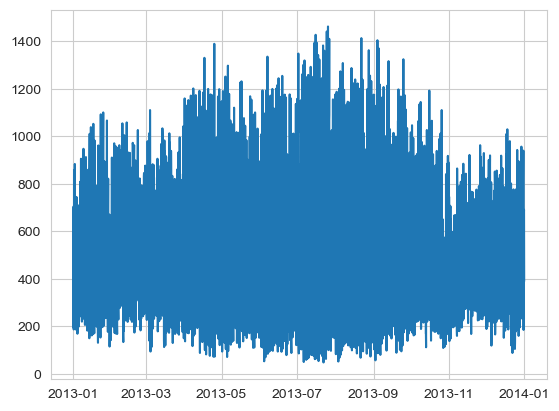

In [45]:
# number can be higher than 181 as there are also generators for other technologies not just electricity
plt.plot(out_incidence_st.sum(axis=1))
out_incidence_st.sum(axis=1).max()

[]

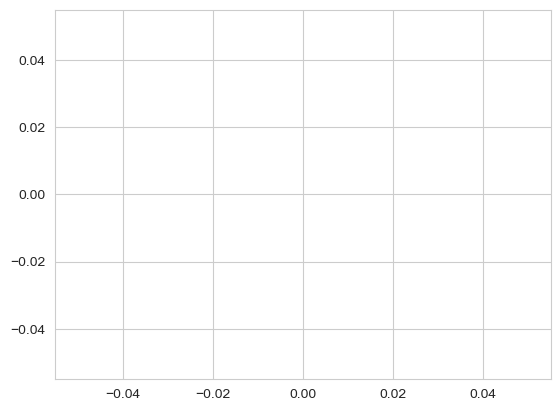

In [46]:
plt.plot()

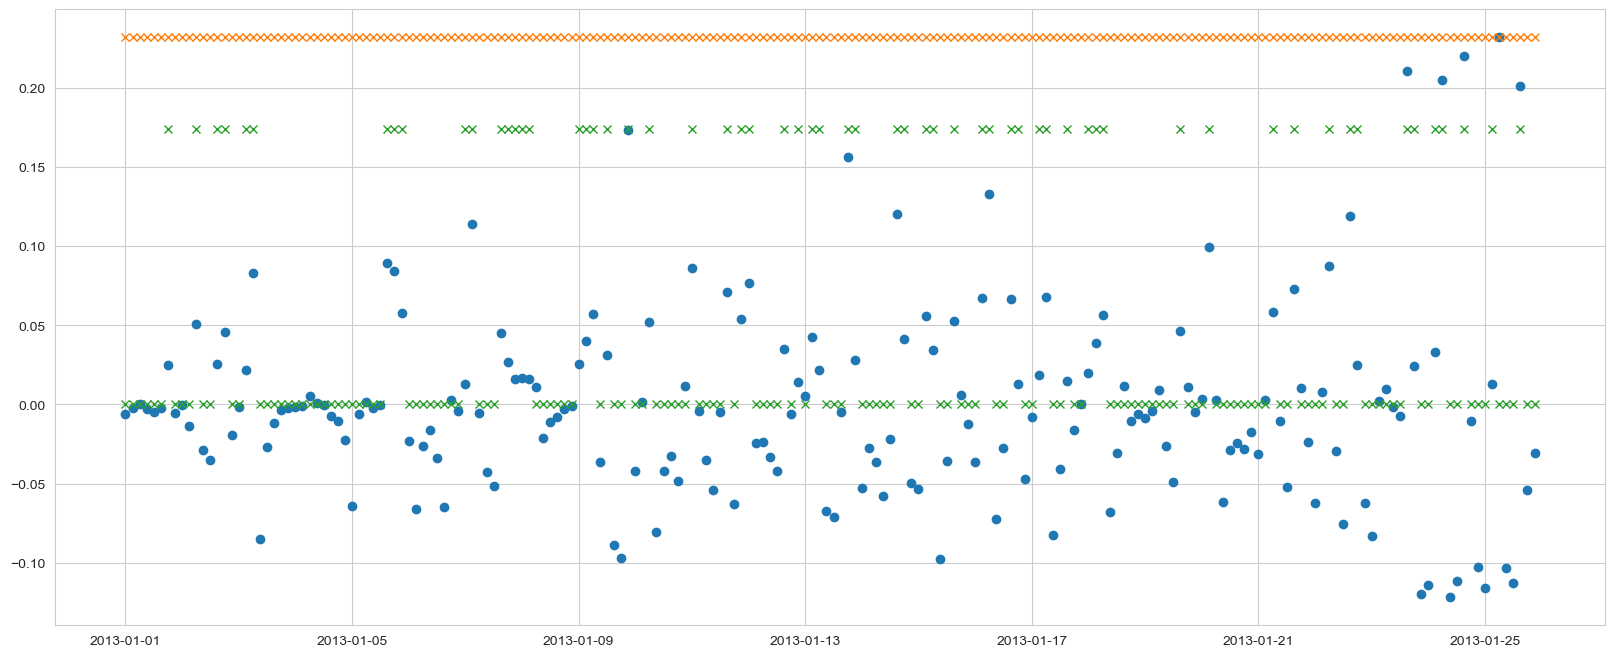

In [47]:
# check results
st = "DE0 20 home battery" # DE0 11 H2 Store, DE0 20 home battery, DE0 15 H2 Store
start = 0
end = 200

plt.figure(figsize=(20, 8))
plt.plot(n.stores_t.p[st][start:end], "o")
plt.plot(max_output_ts[st][start:end], "x")
plt.plot(out_incidence_st[st][start:end]*max_output_ts[st][start:end].mean()*0.75, "x")

### Determine marginal generator

In [48]:
# # show marginal generator for every time step and region
# mg = pd.DataFrame(index=n.buses_t.p.index, columns=n.buses.location.unique().tolist())
# for col in mg.columns:
#     for row in mg.index:
#         mg.loc[row,col] = []
#
# snap = out_incidence.index[0]
# for snap in out_incidence.index:
#     for gen in out_incidence.columns:
#         if out_incidence.loc[snap,gen] == 1:
#             mg.loc[snap,n.buses.loc[n.generators.loc[gen].bus].location].append(gen) # n.generators.bus[gen]
#     for su in  out_incidence_su.columns:
#         if out_incidence_su.loc[snap,su] == 1:
#             mg.loc[snap,n.storage_units.bus[su]].append(su)
#     # for st in  out_incidence_st.columns:
#     #         if out_incidence_st.loc[snap,st] == 1:
#     #             mg.loc[snap,n.buses.loc[n.stores.loc[st].bus].location].append(st)

In [49]:
# save and load
# mg.to_csv("../data/processed/mg_gen_su_v1.csv")
mg_back = pd.read_csv(filepath_or_buffer="../data/processed/mg_all_v1.csv", index_col="snapshot")

### Determine marginal price

In [50]:
n.gener

AttributeError: 'Network' object has no attribute 'gener'

### Investigate case
-> power_balance notebook

In [ ]:
mg_back

In [ ]:
n.buses.loc[pd.Index(n.stores.bus.values)].location

In [ ]:
pd.Index(n.stores.bus.values)

In [ ]:
pd.Index(n.stores.bus.values)

In [ ]:
n.stores.bus.values

### ToDO

- Für einzelne Fälle rausfinden welche die marginal generators sind und deren lmp nachvollziehen. Dann damit die anderen marginal generator berechnen
- idea: if the net flow away from a bus is positive this means that the marginal generator has to be at the bus? -> no, only if all flows away from the bus are positive

In [ ]:
# Lines (what reaches bus?)
# 1. sum of power @ lines with bus as bus0 and p0 (Active power at bus0 (positive if branch is withdrawing power from bus0)
n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1)
# 2. sum of power @ lines with bus as bus1 and p1 (Active power at bus1 (positive if branch is withdrawing power from bus1)
n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
# sum (if negative power is feed into bus)
lines = n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1) + n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
lines[snapshot]

In [ ]:
# loads
loads_index = n.loads[[s in buses for s in n.loads.bus]].bus.index
# active power at bus (positive if net load) in MW
n.loads_t.p.loc[snapshot, loads_index]#.sum()

In [ ]:
# generation in whole region
gens_index = n.generators[[s in buses for s in n.generators.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.generators_t.p.loc[snapshot, gens_index]#.sum(axis=1)

In [ ]:
# generation directly connected to bus
gens_index_direct = n.generators[n.generators.bus == bus].bus.index
n.generators_t.p.loc[snapshot, gens_index_direct]#.sum(axis=1)

In [ ]:
# storages
storage_index = n.storage_units[[s in buses for s in n.storage_units.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.storage_units_t.p.loc[snapshot, storage_index]#.sum(axis=1)

In [ ]:
# storage directly at bus
storage_index_direct = n.storage_units[n.storage_units.bus == bus].bus.index
n.storage_units_t.p.loc[snapshot, storage_index_direct]#.sum(axis=1)

In [ ]:
# stores
stores_index = n.stores[[s in buses for s in n.stores.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.stores_t.p.loc[snapshot, stores_index]#.sum(axis=1)

In [ ]:
# stores directly at bus
stores_index_direct = n.stores[n.stores.bus == bus].bus.index
# active power at bus (positive if net generation) in MW
n.stores_t.p.loc[snapshot, stores_index_direct]#.sum(axis=1)

In [ ]:
# link

In [ ]:
n.links[n.links.bus0 == bus]

In [ ]:
n.links[n.links.bus1 == bus]

In [ ]:
# Links (what reaches bus?)
# 1. sum of power @ links with bus as bus0 and p0 (Active power at bus0 (positive if branch is withdrawing power from bus0)
n.links_t.p0[n.links[n.links.bus0 == bus].index].sum(axis=1)
# 2. sum of power @ links with bus as bus1 and p1 (Active power at bus1 (positive if branch is withdrawing power from bus1)
n.links_t.p1[n.links[n.links.bus1 == bus].index].sum(axis=1)
# sum (if negative power is feed into bus)
links_sum = n.links_t.p0[n.links[n.links.bus0 == bus].index].sum(axis=1) + n.links_t.p1[n.links[n.links.bus1 == bus].index].sum(axis=1)
links_sum[snapshot]

In [ ]:
n.links_t.p0.loc[snapshot , n.links[n.links.bus0 == bus].index]

In [ ]:
n.links_t.p1.loc[snapshot , n.links[n.links.bus1 == bus].index]

In [ ]:
# aggregation for bus0
# balance of electricity feed in and withdrawal via lines
li = lines[snapshot]
# load at direct bus (not other technologies)
lo = n.loads_t.p.loc[snapshot, loads_index][bus].sum()
# generation at direct bus (not other technologies)
gen = n.generators_t.p.loc[snapshot, gens_index_direct].sum()
lk = links_sum[snapshot]

gen - li - lo - lk

In [ ]:
n.loads_t.p.loc[snapshot, loads_index][bus]

In [ ]:
n.buses_t.marginal_price[buses]

In [ ]:
n.stores

In [ ]:
# 17 buses in region AL0 0
n.buses[n.buses.location == "AL0 0"]

In [ ]:
# 181 regions and EU
n.buses.location.unique()

In [ ]:
n.loads[['AL0 0' in s for s in n.loads.index]]

In [ ]:
n.loads.bus.unique()

In [ ]:
n.generators.bus.unique()

In [ ]:
n.storage_units.bus

In [ ]:
n.stores.bus

In [ ]:
n.loads_t.p

In [ ]:
n.loads_t.p.loc["2013-01-02 03:00:00", ['AL0 0' in s for s in n.loads_t.p.columns]]

In [ ]:
n.loads_t.p

In [ ]:
n.loads_t.p_set.loc["2013-01-02 00:00:00", ['AL0 0' in s for s in n.loads_t.p_set.columns]]

In [ ]:
n.buses[['AL0 0' in s for s in n.buses.index]]

In [ ]:
# active power at bus (positive if net generation at bus) (MW)
n.buses_t.p
# 608 MWh missing at ALO 0 that are feed in from other buses / nodes via lines 1,2,3,4
1639.391422 - 1053.551832 - 269.964278

In [ ]:
# marginal cost of generator in currency/MWh
n.generators[['AL0 0' in s for s in n.generators.index]]

In [ ]:
# actual dispatch of the generator
n.generators_t.p.loc["2013-01-02 00:00:00", ['AL0 0' in s for s in n.generators_t.p.columns]]

In [ ]:
n.storage_units[['AL0 0' in s for s in n.storage_units.index]]

In [ ]:
n.storage_units.marginal_cost.describe()

In [ ]:
# Locational marginal price from LOPF from power balance constraint (currency/MWh)
plt.plot(n.buses_t.marginal_price['AL0 0'])

In [ ]:
n.stores[['AL0 0' in s for s in n.stores.index]]

In [ ]:
# active power at bus (positive if net generation) (MW)
n.stores_t.p.loc["2013-01-02 00:00:00", ['AL0 0' in s for s in n.stores_t.p.columns]]

In [ ]:
n.stores.marginal_cost[['AL0 0' in s for s in n.stores.index]]

In [ ]:
n.generators_t.p

In [ ]:
n.lines

In [ ]:
n.lines_t.p0[n.lines[n.lines.bus0 == "AL0 0"].index].sum(axis=1)

In [ ]:
# Active power at bus0 (positive if branch is withdrawing power from bus0).
n.lines_t.p0[["1","2","3","4"]].sum(axis=1)
# -608.163407 is feed into bus ALO 0
# 1053.552001

In [ ]:
n.lines_t.p1[["1","2","3"]].sum(axis=1)

In [ ]:
# no transformers
n.transformers_t

In [ ]:
n.storage_units

In [ ]:
n.buses_t.marginal_price

In [ ]:
import plotly.offline as py
from plotly.graph_objs import *

n.iplot()

In [ ]:
n.buses

In [ ]:
# reconstruction of electricity balance at bus 'AL0 0' at time "2013-01-02 00:00:00"
date = "2013-01-02 00:00:00"
bus = 'AT0 0' # "AT0 0 hydro

# load
load = n.loads_t.p_set.loc[date, [bus]]

# generation
gen = n.generators_t.p.loc[date, [bus in s for s in n.generators_t.p.columns]].sum()

# storage
storage = n.storage_units_t.p.loc[date, [bus in s for s in n.storage_units_t.p.columns]].sum()

# stores
# n.stores_t.p.loc[date, [bus in s for s in n.stores_t.p.columns]]

# lines
lines = n.lines_t.p0.loc[date, n.lines[n.lines.bus0 == bus].index].sum()

# balance
load - gen - storage - lines

In [ ]:
n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)

In [ ]:
n.stores.bus

In [ ]:
# CO2 Preis